<img src='https://www.zyfra.com/img/about/ecology/ecology-flower.png' />

# Zyfra - Predicting the Amount of Recovered Gold

Zyfra is big company working to improve the efficiency and safety of the mining, oil & gas, chemical and engineering industries. 
In this project we need to develop a model that must predict the amount of gold recovered from gold ore after the purification process.
The model will help to optimize the production and eliminate unprofitable parameters.

## Opening and investigating the data

In [1]:
#making sure I and the reviewer have the same versions
#!pip install -U pandas
#!pip install -U matplotlib
#!pip install -U numpy
#!pip install -U sklearn

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [4]:
try:
    # If we are local we open the local database
    gold_recovery_full = pd.read_csv('datasets/gold_recovery_full.csv',sep=',')
    gold_recovery_test = pd.read_csv('datasets/gold_recovery_test.csv',sep=',')
    gold_recovery_train = pd.read_csv('datasets/gold_recovery_train.csv',sep=',')
except:
    # If we are online on the Jupyter Hub, we open the online database
    gold_recovery_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv',sep=',')
    gold_recovery_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv',sep=',')
    gold_recovery_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv',sep=',')


In [5]:
def investigate_data(data):
    print(' ==================== Table ==========================')
    display(data.head().T)
    print(' -------------------- Info ---------------------------')
    print(data.info())
    print('The shape is:', data.shape)
    print(' -------------- Data description ----------------------')
    display(data.describe().T)
    print(data.describe(include=['object']))
    print('Number of duplicated rows :', data.duplicated().sum())

In [6]:
investigate_data(gold_recovery_full)

 ==================== Table ==========================


,0,1,2,3,4
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final.output.concentrate_ag,6.055403,6.029369,6.055926,6.047977,6.148599
final.output.concentrate_pb,9.889648,9.968944,10.213995,9.977019,10.142511
final.output.concentrate_sol,5.507324,5.257781,5.383759,4.858634,4.939416
final.output.concentrate_au,42.19202,42.701629,42.657501,42.689819,42.774141
...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,-498.310211,-500.169983,-500.129135,-499.20164,-501.686727
secondary_cleaner.state.floatbank5_b_air,8.079666,7.984757,8.013877,7.977324,7.894242
secondary_cleaner.state.floatbank5_b_level,-500.470978,-500.582168,-500.517572,-500.255908,-500.356035
secondary_cleaner.state.floatbank6_a_air,14.151341,13.998353,14.028663,14.005551,13.996647


 -------------------- Info ---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,22627.0,4.781559,2.030128,0.000000,4.018525,4.953729,5.862593,16.001945
final.output.concentrate_pb,22629.0,9.095308,3.230797,0.000000,8.750171,9.914519,10.929839,17.031899
final.output.concentrate_sol,22331.0,8.640317,3.785035,0.000000,7.116799,8.908792,10.705824,19.615720
final.output.concentrate_au,22630.0,40.001172,13.398062,0.000000,42.383721,44.653436,46.111999,53.611374
final.output.recovery,20753.0,67.447488,11.616034,0.000000,63.282393,68.322258,72.950836,100.000000
...,...,...,...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,22615.0,-503.323288,72.925589,-799.741097,-500.628697,-499.865158,-498.489381,-244.483566
secondary_cleaner.state.floatbank5_b_air,22615.0,11.626743,5.757449,0.427084,8.037533,10.989756,14.001193,39.846228
secondary_cleaner.state.floatbank5_b_level,22616.0,-500.521502,78.956292,-800.258209,-500.167897,-499.951980,-499.492354,-120.190931
secondary_cleaner.state.floatbank6_a_air,22597.0,17.976810,6.636203,-0.079426,13.968418,18.004215,23.009704,54.876806


                       date
count                 22716
unique                22716
top     2016-01-15 00:00:00
freq                      1
Number of duplicated rows : 0


In [7]:
investigate_data(gold_recovery_test)

 ==================== Table ==========================


,0,1,2,3,4
date,2016-09-01 00:59:59,2016-09-01 01:59:59,2016-09-01 02:59:59,2016-09-01 03:59:59,2016-09-01 04:59:59
primary_cleaner.input.sulfate,210.800909,215.392455,215.259946,215.336236,199.099327
primary_cleaner.input.depressant,14.993118,14.987471,12.884934,12.006805,10.68253
primary_cleaner.input.feed_size,8.08,8.08,7.786667,7.64,7.53
primary_cleaner.input.xanthate,1.005021,0.990469,0.996043,0.863514,0.805575
primary_cleaner.state.floatbank8_a_air,1398.981301,1398.777912,1398.493666,1399.618111,1401.268123
primary_cleaner.state.floatbank8_a_level,-500.225577,-500.057435,-500.86836,-498.863574,-500.808305
primary_cleaner.state.floatbank8_b_air,1399.144926,1398.055362,1398.860436,1397.44012,1398.128818
primary_cleaner.state.floatbank8_b_level,-499.919735,-499.778182,-499.764529,-499.211024,-499.504543
primary_cleaner.state.floatbank8_c_air,1400.102998,1396.151033,1398.075709,1400.129303,1402.172226


 -------------------- Info ---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatban

,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.sulfate,5554.0,170.515243,49.608602,0.000103,143.340022,176.103893,207.240761,274.409626
primary_cleaner.input.depressant,5572.0,8.482873,3.353105,0.000031,6.411500,8.023252,10.017725,40.024582
primary_cleaner.input.feed_size,5856.0,7.264651,0.611526,5.650000,6.885625,7.259333,7.650000,15.500000
primary_cleaner.input.xanthate,5690.0,1.321420,0.693246,0.000003,0.888769,1.183362,1.763797,5.433169
primary_cleaner.state.floatbank8_a_air,5840.0,1481.990241,310.453166,0.000000,1497.190681,1554.659783,1601.681656,2212.432090
primary_cleaner.state.floatbank8_a_level,5840.0,-509.057796,61.339256,-799.773788,-500.455211,-499.997402,-499.575313,-57.195404
primary_cleaner.state.floatbank8_b_air,5840.0,1486.908670,313.224286,0.000000,1497.150234,1553.268084,1601.784707,1975.147923
primary_cleaner.state.floatbank8_b_level,5840.0,-511.743956,67.139074,-800.029078,-500.936639,-500.066588,-499.323361,-142.527229
primary_cleaner.state.floatbank8_c_air,5840.0,1468.495216,309.980748,0.000000,1437.050321,1546.160672,1600.785573,1715.053773
primary_cleaner.state.floatbank8_c_level,5840.0,-509.741212,62.671873,-799.995127,-501.300441,-500.079537,-499.009545,-150.937035


                       date
count                  5856
unique                 5856
top     2016-09-01 00:59:59
freq                      1
Number of duplicated rows : 0


In [8]:
investigate_data(gold_recovery_train)

 ==================== Table ==========================


,0,1,2,3,4
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final.output.concentrate_ag,6.055403,6.029369,6.055926,6.047977,6.148599
final.output.concentrate_pb,9.889648,9.968944,10.213995,9.977019,10.142511
final.output.concentrate_sol,5.507324,5.257781,5.383759,4.858634,4.939416
final.output.concentrate_au,42.19202,42.701629,42.657501,42.689819,42.774141
...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,-498.310211,-500.169983,-500.129135,-499.20164,-501.686727
secondary_cleaner.state.floatbank5_b_air,8.079666,7.984757,8.013877,7.977324,7.894242
secondary_cleaner.state.floatbank5_b_level,-500.470978,-500.582168,-500.517572,-500.255908,-500.356035
secondary_cleaner.state.floatbank6_a_air,14.151341,13.998353,14.028663,14.005551,13.996647


 -------------------- Info ---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,16788.0,4.716907,2.096718,0.000000,3.971262,4.869346,5.821176,16.001945
final.output.concentrate_pb,16788.0,9.113559,3.389495,0.000000,8.825748,10.065316,11.054809,17.031899
final.output.concentrate_sol,16490.0,8.301123,3.825760,0.000000,6.939185,8.557228,10.289741,18.124851
final.output.concentrate_au,16789.0,39.467217,13.917227,0.000000,42.055722,44.498874,45.976222,53.611374
final.output.recovery,15339.0,67.213166,11.960446,0.000000,62.625685,67.644601,72.824595,100.000000
...,...,...,...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,16775.0,-500.230146,76.983542,-799.741097,-500.530594,-499.784231,-496.531781,-275.073125
secondary_cleaner.state.floatbank5_b_air,16775.0,12.377241,6.219989,0.427084,8.925586,11.092839,15.979467,39.846228
secondary_cleaner.state.floatbank5_b_level,16776.0,-498.956257,82.146207,-800.258209,-500.147603,-499.933330,-498.418000,-120.190931
secondary_cleaner.state.floatbank6_a_air,16757.0,18.429208,6.958294,0.024270,13.977626,18.034960,24.984992,54.876806


                       date
count                 16860
unique                16860
top     2016-01-15 00:00:00
freq                      1
Number of duplicated rows : 0


In [9]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [10]:
print(gold_recovery_train[gold_recovery_train['rougher.output.concentrate_au'].isnull()])

                      date  final.output.concentrate_ag  \
746    2016-02-15 02:00:00                          NaN   
1310   2016-03-09 14:00:00                          NaN   
1311   2016-03-09 15:00:00                          NaN   
1312   2016-03-09 16:00:00                          NaN   
1930   2016-04-04 10:00:00                          NaN   
...                    ...                          ...   
16163  2018-07-20 10:59:59                         0.01   
16164  2018-07-20 11:59:59                         0.01   
16200  2018-07-21 23:59:59                         0.01   
16201  2018-07-22 00:59:59                         0.01   
16241  2018-07-23 16:59:59                         0.01   

       final.output.concentrate_pb  final.output.concentrate_sol  \
746                            NaN                           NaN   
1310                           NaN                           NaN   
1311                           NaN                           NaN   
1312               

In [11]:
gold_recovery_full[gold_recovery_full['secondary_cleaner.state.floatbank6_a_level'].isnull()]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
154,2016-01-21 10:00:00,5.782224,10.969985,9.30126,43.181003,74.257359,11.95976,2.064173,15.139256,3.091437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
746,2016-02-15 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1310,2016-03-09 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1311,2016-03-09 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1312,2016-03-09 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22019,2018-07-20 10:59:59,0.010000,0.010000,0.01000,0.010000,NaN,0.00000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22020,2018-07-20 11:59:59,0.010000,0.010000,0.01000,0.010000,NaN,0.00000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22056,2018-07-21 23:59:59,0.010000,0.010000,0.01000,0.010000,NaN,0.00000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22057,2018-07-22 00:59:59,0.010000,0.010000,0.01000,0.010000,NaN,0.00000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

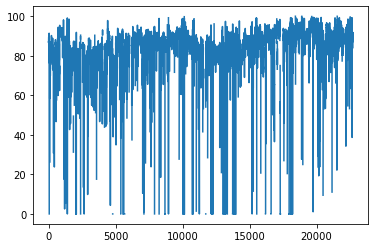

In [12]:
gold_recovery_full['rougher.output.recovery'].plot()

In [13]:
def checking_nulls(df):
    total=0
    for col in df.columns:
        print('Checking column \'{}\' for null or 0 values: '.format(col),end=': ')
        zero=df[col].isnull().sum() +(df[col] < 1.011).sum()
        total+=zero
        print(zero,'null or zeroes')
    print ('In total we found {} nulls which represents {:.4%} of the total data.'.format(total,total/(df.shape[0]*(df.shape[1]-1))))

In [14]:
checking_nulls(gold_recovery_train.drop('date',axis=1))

Checking column 'final.output.concentrate_ag' for null or 0 values: : 1776 null or zeroes
Checking column 'final.output.concentrate_pb' for null or 0 values: : 1754 null or zeroes
Checking column 'final.output.concentrate_sol' for null or 0 values: : 2075 null or zeroes
Checking column 'final.output.concentrate_au' for null or 0 values: : 1740 null or zeroes
Checking column 'final.output.recovery' for null or 0 values: : 1616 null or zeroes
Checking column 'final.output.tail_ag' for null or 0 values: : 1757 null or zeroes
Checking column 'final.output.tail_pb' for null or 0 values: : 2453 null or zeroes
Checking column 'final.output.tail_sol' for null or 0 values: : 1875 null or zeroes
Checking column 'final.output.tail_au' for null or 0 values: : 1937 null or zeroes
Checking column 'primary_cleaner.input.sulfate' for null or 0 values: : 1543 null or zeroes
Checking column 'primary_cleaner.input.depressant' for null or 0 values: : 1701 null or zeroes
Checking column 'primary_cleaner.in

In [15]:
def checking_outliers(df,n_std):
    total=0
    for col in df.columns:
        print('Checking column \'{}\' for outliers bigger than {} standard deviations'.format(col,n_std),end=': ')
        mean = df[col].mean()
        sd = df[col].std()
        outlier=df[(df[col] > mean+(n_std*sd))].shape[0]+df[(df[col] < mean-(n_std*sd))].shape[0]
        total+=outlier
        print(outlier,'outliers')
    print ('In total we found {} outliers which represents {:.4%} of the total data.'.format(total,total/(df.shape[0]*(df.shape[1]-1))))
checking_outliers(gold_recovery_train.drop('date',axis=1),3)

Checking column 'final.output.concentrate_ag' for outliers bigger than 3 standard deviations: 85 outliers
Checking column 'final.output.concentrate_pb' for outliers bigger than 3 standard deviations: 0 outliers
Checking column 'final.output.concentrate_sol' for outliers bigger than 3 standard deviations: 0 outliers
Checking column 'final.output.concentrate_au' for outliers bigger than 3 standard deviations: 0 outliers
Checking column 'final.output.recovery' for outliers bigger than 3 standard deviations: 185 outliers
Checking column 'final.output.tail_ag' for outliers bigger than 3 standard deviations: 0 outliers
Checking column 'final.output.tail_pb' for outliers bigger than 3 standard deviations: 1 outliers
Checking column 'final.output.tail_sol' for outliers bigger than 3 standard deviations: 3 outliers
Checking column 'final.output.tail_au' for outliers bigger than 3 standard deviations: 74 outliers
Checking column 'primary_cleaner.input.sulfate' for outliers bigger than 3 standard

### Preliminary conclusion after data investigation

We notice we have many null values, also many values of 0 (there is no way a concentration of material to be truly 0) which seem to be out of place. This can be of two types:
- When there is a malfunction and the treatment process is stopped for a whole batch of material
- When there is a malfunction in a singular sensor but the treatment process in unimpeded.

If a batch hasn't completed the purification process (as evidenced by the existence of several `Null` values) it should not take part in training the model and should be dropped.
If there is only one Null value, meaning the sensor for that specific stage of the purification process failed, we can try to infer its value from+ the previous and next values.

We also can see that we have numerous outlying values. We should remove them from the training data set, as it's probably corrupted data.


Check that is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

In order to calculate the recovery we are using the following formula:

<img src='https://pictures.s3.yandex.net/resources/Recovery_1576238822_1589899219.jpg' />

    C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
    F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
    T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

In [16]:

C = gold_recovery_train.dropna()['rougher.output.concentrate_au']
F = gold_recovery_train.dropna()['rougher.input.feed_au']
T = gold_recovery_train.dropna()['rougher.output.tail_au']
calculated_recovery = C / F * (F - T) / (C - T) * 100

rougher_recovery_mae = mean_absolute_error(calculated_recovery,
                                           gold_recovery_train.dropna()['rougher.output.recovery'])

In [17]:
print('Mean absolute error between our calculated recovery formula and the output recovery is {:.15f}'.format(rougher_recovery_mae))

Mean absolute error between our calculated recovery formula and the output recovery is 0.000000000000011


We see that the rougher output recovery is nearly identical to the one calculated with the formula.

 ### Features not available in the test set
  Let's see the features not available in the test set. What are these parameters? What is their type?

In [18]:
gold_recovery_full.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [19]:
gold_recovery_train.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [20]:
def remove_duplicates(list1,list2):
    unique_l1=list1
    unique_l2=list2
    count_l1=0
    count_l2=0
    for count_l1 in range(len(list1)):
        to_check=list1[count_l1]
        if to_check in unique_l2:
            unique_l1=np.delete(unique_l1,to_check)
            unique_l2=np.delete(unique_l2,to_check)

In [21]:
def get_uniques(list1,list2):
    unique_list=[]
    for count_l1 in range(len(list1)):
        to_check=list1[count_l1]
        if to_check not in list2:
            unique_list.append(to_check)
    return unique_list

In [22]:
not_in_test_set=get_uniques(gold_recovery_full.columns,gold_recovery_test.columns)

Let's see what missing columns we lack in the test set

In [23]:
not_in_test_set

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

So we see that we are missing exactly the columns that hold the outputs after each stage in the refinement process. These makes sense as these values couldn't be known in advance, they are a result of the refinement process. But in order to score our models, we need to copy from the full data the target columns for the test set.

In [24]:
#Copying the necessary columns to the test set
fixed_columns = ['date','rougher.output.recovery', 'final.output.recovery']
gold_recovery_test = pd.merge(gold_recovery_test, gold_recovery_full[fixed_columns],on='date',how='left')
#Dropping superfluous columns
gold_recovery_train = gold_recovery_train.drop(columns=[x for x in gold_recovery_train if x not in gold_recovery_test], axis=1)
gold_recovery_test = gold_recovery_test.drop(columns=[x for x in gold_recovery_test if x not in gold_recovery_train], axis=1)

## Data Preparation

In [25]:
gold_recovery_train.head()

,date,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,70.541216,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,69.266198,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,68.116445,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,68.347543,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,66.927016,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Let's check if our data has outliers

In [26]:
#since we need to apply this to all 3 datasets, we make this into a function.
def print_outliers(df,n_std):
    for col in df.columns.drop('date'):
        mean = df[col].mean()
        sd = df[col].std()
        print('Column',col,'Mean',mean,'sd',sd,'outlier',len(df.loc[(df[col] < mean-(n_std*sd)),col]))
    print('Outliers removed.')

In [27]:
print_outliers(gold_recovery_train,3)

Column final.output.recovery Mean 67.21316570359656 sd 11.960445860620379 outlier 185
Column primary_cleaner.input.sulfate Mean 129.47978937338982 sd 45.386931250128995 outlier 0
Column primary_cleaner.input.depressant Mean 8.625020910470862 sd 3.6986330593240813 outlier 0
Column primary_cleaner.input.feed_size Mean 7.29728487125721 sd 0.6191657608469666 outlier 40
Column primary_cleaner.input.xanthate Mean 0.8438118450282122 sd 0.4190980623875011 outlier 0
Column primary_cleaner.state.floatbank8_a_air Mean 1521.2916912426303 sd 380.0644534750447 outlier 887
Column primary_cleaner.state.floatbank8_a_level Mean -505.81110252919757 sd 77.64028503735642 outlier 951
Column primary_cleaner.state.floatbank8_b_air Mean 1523.880014831629 sd 381.2453238961324 outlier 885
Column primary_cleaner.state.floatbank8_b_level Mean -507.3461051526664 sd 79.83073846360801 outlier 962
Column primary_cleaner.state.floatbank8_c_air Mean 1514.35113065211 sd 396.4931060009065 outlier 970
Column primary_cleane

We want to scale the data, so we won't have some features weighted more than necessary in our models

In [28]:
gold_recovery_ftrimmed=gold_recovery_full.drop(not_in_test_set,axis=1)
scaler = StandardScaler()
to_scale = [x for x in gold_recovery_train.columns if x not in fixed_columns]
gold_recovery_train_scaled=pd.DataFrame(scaler.fit_transform(gold_recovery_train[to_scale].copy()),columns=to_scale)
gold_recovery_test_scaled=pd.DataFrame(scaler.transform(gold_recovery_test[to_scale].copy()),columns=to_scale)
gold_recovery_full_scaled=pd.DataFrame(scaler.transform(gold_recovery_ftrimmed[to_scale].copy()),columns=to_scale)

In [29]:
gold_recovery_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


We see the scaling was performed successfully

In [30]:
#since we need to apply this to all 3 datasets, we make this into a function.
def remove_outliers(df,n_std):
    for col in df.columns:
        mean = df[col].mean()
        sd = df[col].std()
        df.loc[(df[col] > mean+(n_std*sd)),col]=np.nan  #remove upper outliers
        df.loc[(df[col] < mean-(n_std*sd)),col]=np.nan  #remove lower outliers
    print('Outliers removed.')
    return df

In [31]:
features=[x for x in gold_recovery_ftrimmed.columns if x not in fixed_columns]

In [32]:
gold_recovery_test_clean=remove_outliers(gold_recovery_test_scaled,3)
gold_recovery_train_clean=remove_outliers(gold_recovery_train_scaled,3)
gold_recovery_full_clean=remove_outliers(gold_recovery_full_scaled,3)
gold_recovery_full_unscaled=remove_outliers(gold_recovery_ftrimmed[features],3)

Outliers removed.
Outliers removed.
Outliers removed.
Outliers removed.


What are the features of our model?

In [33]:
features_columns= [x for x in gold_recovery_train_clean.columns if x not in ['date', 'rougher.output.recovery', 'final.output.recovery']]

In [34]:
features_columns

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rough

Now we use KNNImputer to fill the remaining null values from their closest neighbors

In [35]:
imputer = KNNImputer()
# We fill with KNN the null values but only in the feature columns,
gold_recovery_train_clean= pd.DataFrame(imputer.fit_transform(gold_recovery_train_clean), columns=features_columns)
gold_recovery_test_clean = pd.DataFrame(imputer.transform(gold_recovery_test_clean), columns=features_columns)

In [36]:
gold_recovery_full_clean = pd.DataFrame(imputer.transform(gold_recovery_full_clean), columns=features_columns)

In [37]:
gold_recovery_full_unscaled = pd.DataFrame(imputer.transform(gold_recovery_full_unscaled), columns=features_columns)

Now we reattach the targets and the date columns.

In [38]:
gold_recovery_train_clean= pd.concat([gold_recovery_train[['rougher.output.recovery', 'final.output.recovery']]] + [gold_recovery_train_clean], axis = 1)
gold_recovery_test_clean = pd.concat([gold_recovery_test[['rougher.output.recovery', 'final.output.recovery']]] + [gold_recovery_test_clean], axis=1)
gold_recovery_full_clean = pd.concat([gold_recovery_full[['rougher.output.recovery', 'final.output.recovery']]] + [gold_recovery_full_clean], axis=1)
gold_recovery_full_unscaled = pd.concat([gold_recovery_full[['rougher.output.recovery', 'final.output.recovery']]] + [gold_recovery_full_unscaled], axis=1)


In [39]:
gold_recovery_train_clean

,rougher.output.recovery,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,87.107763,70.541216,-0.052611,0.406453,-0.076371,0.345866,0.074948,0.088861,0.072276,-0.113460,...,-0.738787,-0.098154,-0.446449,-0.314571,-0.856516,0.024940,-0.690950,-0.018440,-0.614805,-1.089046
1,86.843261,69.266198,-0.084841,0.451865,-0.076371,0.379043,0.144388,0.063192,0.136584,0.093704,...,-0.742354,-0.133711,-0.471353,-0.276705,-0.839892,0.000782,-0.706210,-0.019793,-0.636792,-1.010584
2,86.842308,68.116445,-0.124709,0.727659,-0.076371,0.351847,0.211193,0.074877,0.200682,0.084410,...,-0.739051,-0.098542,-0.477646,-0.274488,-0.835259,0.001312,-0.701528,-0.019007,-0.632436,-1.031839
3,87.226430,68.347543,-0.158853,0.729244,-0.076371,0.364907,0.207016,0.062590,0.201397,0.096069,...,-0.735928,-0.078924,-0.463182,-0.275162,-0.849971,0.013360,-0.707405,-0.015822,-0.635758,-1.013292
4,86.688794,66.927016,-0.253200,0.889166,-0.076371,0.396238,0.210623,0.088045,0.203439,0.087974,...,-0.737267,-0.066912,-0.470930,-0.273598,-0.856505,-0.018921,-0.720762,-0.017041,-0.637037,-1.032737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,89.574376,73.755150,-0.134360,-0.161171,-1.287714,1.098633,0.334505,1.357956,0.327521,1.340206,...,0.570921,-0.082587,0.871717,-0.258898,0.325781,0.005141,0.100304,-0.014602,0.226877,0.265722
16856,87.724007,69.049291,-0.189523,-0.179095,-1.287714,1.094306,0.338186,1.363767,0.329135,1.348203,...,0.560547,-0.087833,0.876400,-0.264619,0.324683,-0.002144,0.092737,-0.011430,0.221223,0.269024
16857,88.890579,67.002189,-0.524698,-0.181129,-1.287714,1.126535,0.336466,1.364313,0.328714,1.348750,...,0.568628,-0.088998,0.862326,-0.260207,0.327757,-0.002871,0.103892,-0.011664,0.224441,0.262845
16858,89.858126,65.523246,-0.674208,-0.173274,-1.287714,0.950062,0.329575,1.376054,0.326131,1.339910,...,0.569971,-0.082416,0.879477,-0.265328,0.321900,0.012435,0.098904,-0.012417,0.227761,0.274417


Now we drop lines that have a high number of `null` or very close to 0 values, as probably there are systemic failures in there.

In [40]:
#since we need to apply this to all 3 datasets, we make this into a function.
def clean_gold_data(df,tolerance):
    #We drop rows with more than three null or 0 and 0.01 values
    df_clean=df.mask(abs(df)<0.015,np.nan)
    df_clean.dropna(thresh=df.shape[1]-tolerance,inplace=True)
    print('Rows with more than three null values dropped.')
    return df_clean

In [41]:
gold_recovery_train_clean=clean_gold_data(gold_recovery_train_clean,3) # we settle for a maximum of 3 null values on one row.
gold_recovery_test_clean=clean_gold_data(gold_recovery_test_clean,3)
gold_recovery_full_clean=clean_gold_data(gold_recovery_full_clean,3)
gold_recovery_full_unscaled=clean_gold_data(gold_recovery_full_unscaled,3)

Rows with more than three null values dropped.
Rows with more than three null values dropped.
Rows with more than three null values dropped.
Rows with more than three null values dropped.


We see that indeed the rows with many `null` values were dropped

Now we reattach the date columns.

In [42]:
gold_recovery_train_clean= pd.concat([gold_recovery_train['date']] + [gold_recovery_train_clean], axis = 1)
gold_recovery_test_clean = pd.concat([gold_recovery_test['date']] + [gold_recovery_test_clean], axis=1)
gold_recovery_full_clean = pd.concat([gold_recovery_full['date']] + [gold_recovery_full_clean], axis=1)
gold_recovery_full_unscaled = pd.concat([gold_recovery_full['date']] + [gold_recovery_full_unscaled], axis=1)


The final step is to drop th rows that have null values in the target column, as they cannot help us train the model.

In [43]:
gold_recovery_train_clean = gold_recovery_train_clean.dropna().reset_index(drop=True)
gold_recovery_test_clean = gold_recovery_test_clean.dropna().reset_index(drop=True)
gold_recovery_full_clean = gold_recovery_full_clean.dropna().reset_index(drop=True)
gold_recovery_full_unscaled = gold_recovery_full_unscaled.dropna().reset_index(drop=True)

In [44]:
gold_recovery_train_clean

,date,rougher.output.recovery,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,87.107763,70.541216,-0.052611,0.406453,-0.076371,0.345866,0.074948,0.088861,0.072276,...,-0.738787,-0.098154,-0.446449,-0.314571,-0.856516,0.024940,-0.690950,-0.018440,-0.614805,-1.089046
1,2016-01-18 16:00:00,58.300095,43.677458,0.567687,1.450831,-0.076371,0.634630,0.074928,0.068107,0.068292,...,-0.743713,-0.660998,-0.481973,-0.825012,-0.858684,-0.054214,-0.713783,-0.016990,-0.923264,-1.001635
2,2016-01-19 02:00:00,26.275908,58.017871,-2.516370,-1.807309,-0.076371,-1.583671,0.067516,0.060183,0.069905,...,-0.748880,-2.474373,-0.460075,-0.930875,-0.845670,-0.161639,-0.712318,-0.018495,-0.929170,-1.115036
3,2016-01-21 03:00:00,81.342775,70.157318,1.027252,1.466950,-0.076371,0.883332,0.078527,0.069152,0.061412,...,-0.740073,-0.658446,-0.455176,-0.832102,-0.852289,0.150981,-0.712680,-0.015404,-0.920786,-1.039688
4,2016-01-21 05:00:00,81.645545,69.302289,1.425983,1.713094,-0.076371,0.866770,0.077608,0.070280,0.073756,...,-0.740481,-0.664565,-0.444229,-0.841388,-0.842690,0.464980,-0.709839,-0.017327,-0.923058,-1.043625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,2018-08-10 22:59:59,88.873191,64.430814,-0.776493,-0.442518,-1.336168,-0.326760,0.343266,1.430268,0.331211,...,1.148655,-0.090603,1.378120,-0.262671,0.615729,-0.021007,0.425232,-0.015632,0.659690,0.215160
2721,2018-08-13 00:59:59,90.555545,72.438252,1.637141,1.726972,-0.778951,0.532107,0.339933,1.370379,0.331814,...,0.564345,-0.083415,0.875400,-0.260236,0.320417,-0.024593,0.102397,-0.016224,0.223527,0.200952
2722,2018-08-13 22:59:59,93.793813,81.686704,0.833742,1.719676,-1.691495,0.153878,0.331243,1.363508,0.325092,...,0.569616,-0.110053,0.874983,-0.256163,0.324183,-0.119485,0.110580,0.162474,0.227919,0.846382
2723,2018-08-14 08:59:59,93.834227,79.526820,0.728383,1.708341,-0.870473,0.382596,0.335911,1.363954,0.332008,...,0.566919,-0.078181,0.873792,-0.250491,0.316704,-0.029294,0.102431,-0.016032,0.228491,0.239861


In [45]:
gold_recovery_full_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3108 entries, 0 to 3107
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        3108 non-null   object 
 1   rougher.output.recovery                     3108 non-null   float64
 2   final.output.recovery                       3108 non-null   float64
 3   primary_cleaner.input.sulfate               3108 non-null   float64
 4   primary_cleaner.input.depressant            3108 non-null   float64
 5   primary_cleaner.input.feed_size             3108 non-null   float64
 6   primary_cleaner.input.xanthate              3108 non-null   float64
 7   primary_cleaner.state.floatbank8_a_air      3108 non-null   float64
 8   primary_cleaner.state.floatbank8_a_level    3108 non-null   float64
 9   primary_cleaner.state.floatbank8_b_air      3108 non-null   float64
 10  primary_clea

Finally, no `nulls` anywhere! How wonderful!

Now our data is ready!

## 2. Analyzing the data

### 2.1. Evolution of the concentrations of metals (Au, Ag, Pb) depending on the purification stage.

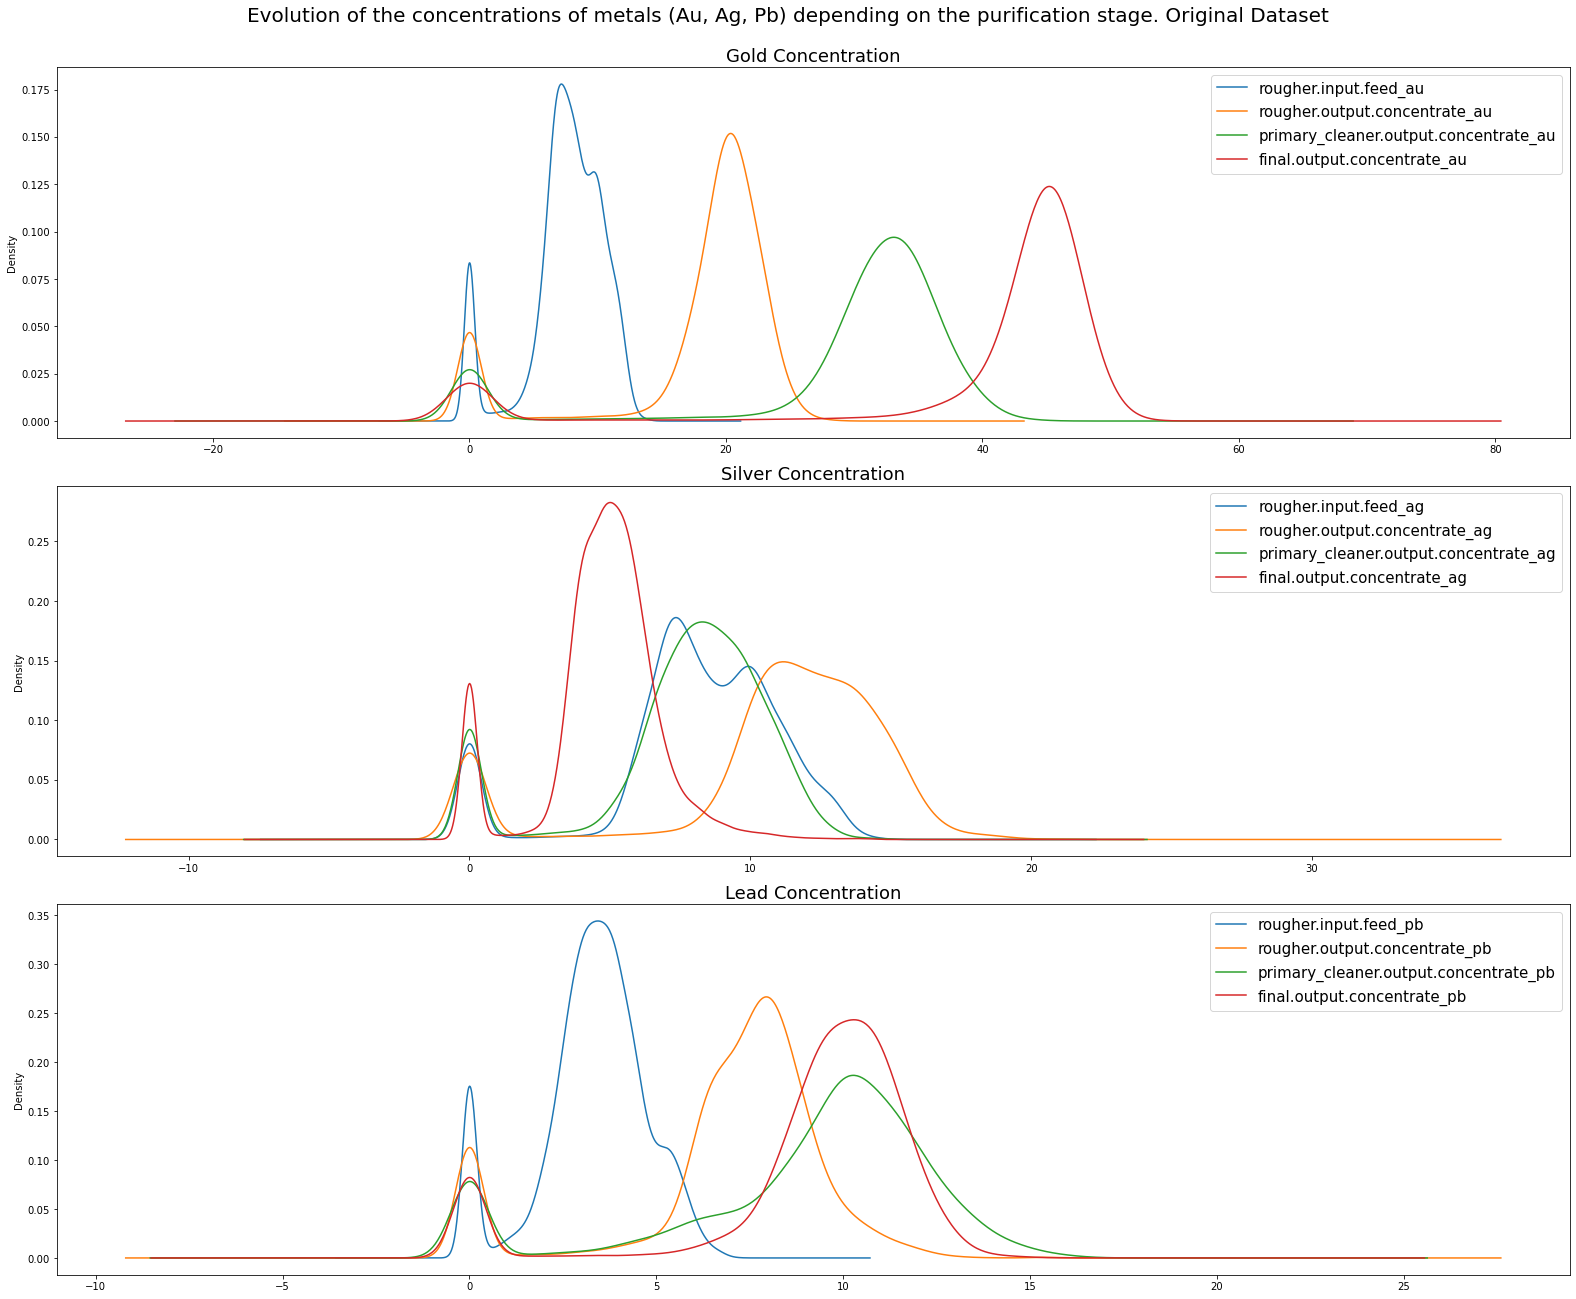

In [46]:
result_columns = ["rougher.input.feed", "rougher.output.concentrate", "primary_cleaner.output.concentrate", "final.output.concentrate"]
metals = ['_au' ,'_ag','_pb']
titles=['Gold' ,'Silver', 'Lead']
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(22, 18), sharey=False)
fig.suptitle('Evolution of the concentrations of metals (Au, Ag, Pb) depending on the purification stage. Original Dataset', fontsize=20, y=1)
for i in range(3):
    gold_recovery_full[[feature + metals[i] for feature in result_columns]].\
        plot.kde(ax=ax[i], label=[feature + metals[i] for feature in result_columns])
    ax[i].set_title(titles[i]+' Concentration', fontsize=18)
    ax[i].legend(fontsize=15)

#ax.set_title('Evolution of the concentrations of metals (Au, Ag, Pb) depending on the purification stage')

fig.tight_layout()

We see how nicely the concentration of gold grows after each stage in the purification process. The concentration of silver is very low in the last stage but the concentration of lead is increasing. We also see many anomalous around 0.

#### Conclusion
In the cleaned data set, the anomalous results are gone, but because of the scaling,  the graph has distorted. Nevertheless we can still se clearly  how in the last stage we have the highes concentration of gold.

### 2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

In [47]:
gold_recovery_test_clean

,date,rougher.output.recovery,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 04:59:59,83.236367,61.467078,1.533961,0.556307,0.375864,-0.091238,-0.315807,0.064438,-0.329853,...,-1.028120,-0.078089,-1.120773,-0.266254,-1.122481,-0.120764,-1.192894,-0.017089,0.944818,0.271425
1,2016-09-08 07:59:59,80.098943,59.196590,0.034235,-0.450287,0.828099,-0.841103,-0.587133,0.073261,-0.600974,...,-1.622750,-0.066794,-1.649855,-1.287119,-1.135220,-1.298025,-1.487020,-1.217777,0.223585,-1.017883
2,2016-09-09 03:59:59,82.695884,58.552267,-0.397889,-0.438075,1.393392,-0.831017,-0.571402,0.043112,-0.592658,...,-1.606069,-0.068396,-1.648824,-1.383882,-1.154492,-1.272591,-1.515710,-1.216469,0.235050,-1.026068
3,2016-09-09 08:59:59,82.061563,63.164267,-0.642466,-0.453017,0.989611,-0.779527,-0.583052,0.062579,-0.597580,...,-1.619897,-0.065456,-1.646035,-1.377497,-1.123029,-1.336314,-1.493649,-1.156887,0.228526,-1.024800
4,2016-09-10 11:59:59,86.057861,67.095935,-0.274578,-0.721846,0.860401,-0.044618,-0.582540,0.070690,-0.585864,...,-1.607484,-0.065988,-1.629771,-0.265816,-1.125363,0.022086,-1.491029,-0.019457,0.234446,-1.027650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,2017-12-18 16:59:59,91.051989,71.614316,2.732088,1.728211,1.797173,1.305400,0.073637,0.048208,0.072237,...,-1.329412,-0.119578,-0.781936,-0.264331,-0.694748,-0.046706,-0.541263,-0.018992,-0.923098,0.285839
369,2017-12-18 21:59:59,91.348859,64.460985,2.718390,1.722104,0.505073,1.264997,0.068146,0.080619,0.071866,...,0.132445,-0.076916,0.033939,-0.271000,-0.710673,-0.208183,-0.533118,0.016131,-0.925963,0.139598
370,2017-12-19 14:59:59,92.708003,75.856731,2.044194,1.453236,2.023291,0.029787,0.085337,0.074622,0.063852,...,0.131084,-0.075030,0.049630,-0.262853,-0.709113,-0.019410,-0.538902,-0.019553,-0.928688,0.282691
371,2017-12-23 11:59:59,94.464699,77.240171,1.807161,1.721228,0.327410,1.041434,0.216374,0.079760,0.204365,...,0.127253,-0.073617,0.050024,-0.266473,-0.701582,-0.033257,-0.678811,-0.022294,-0.923754,0.260496


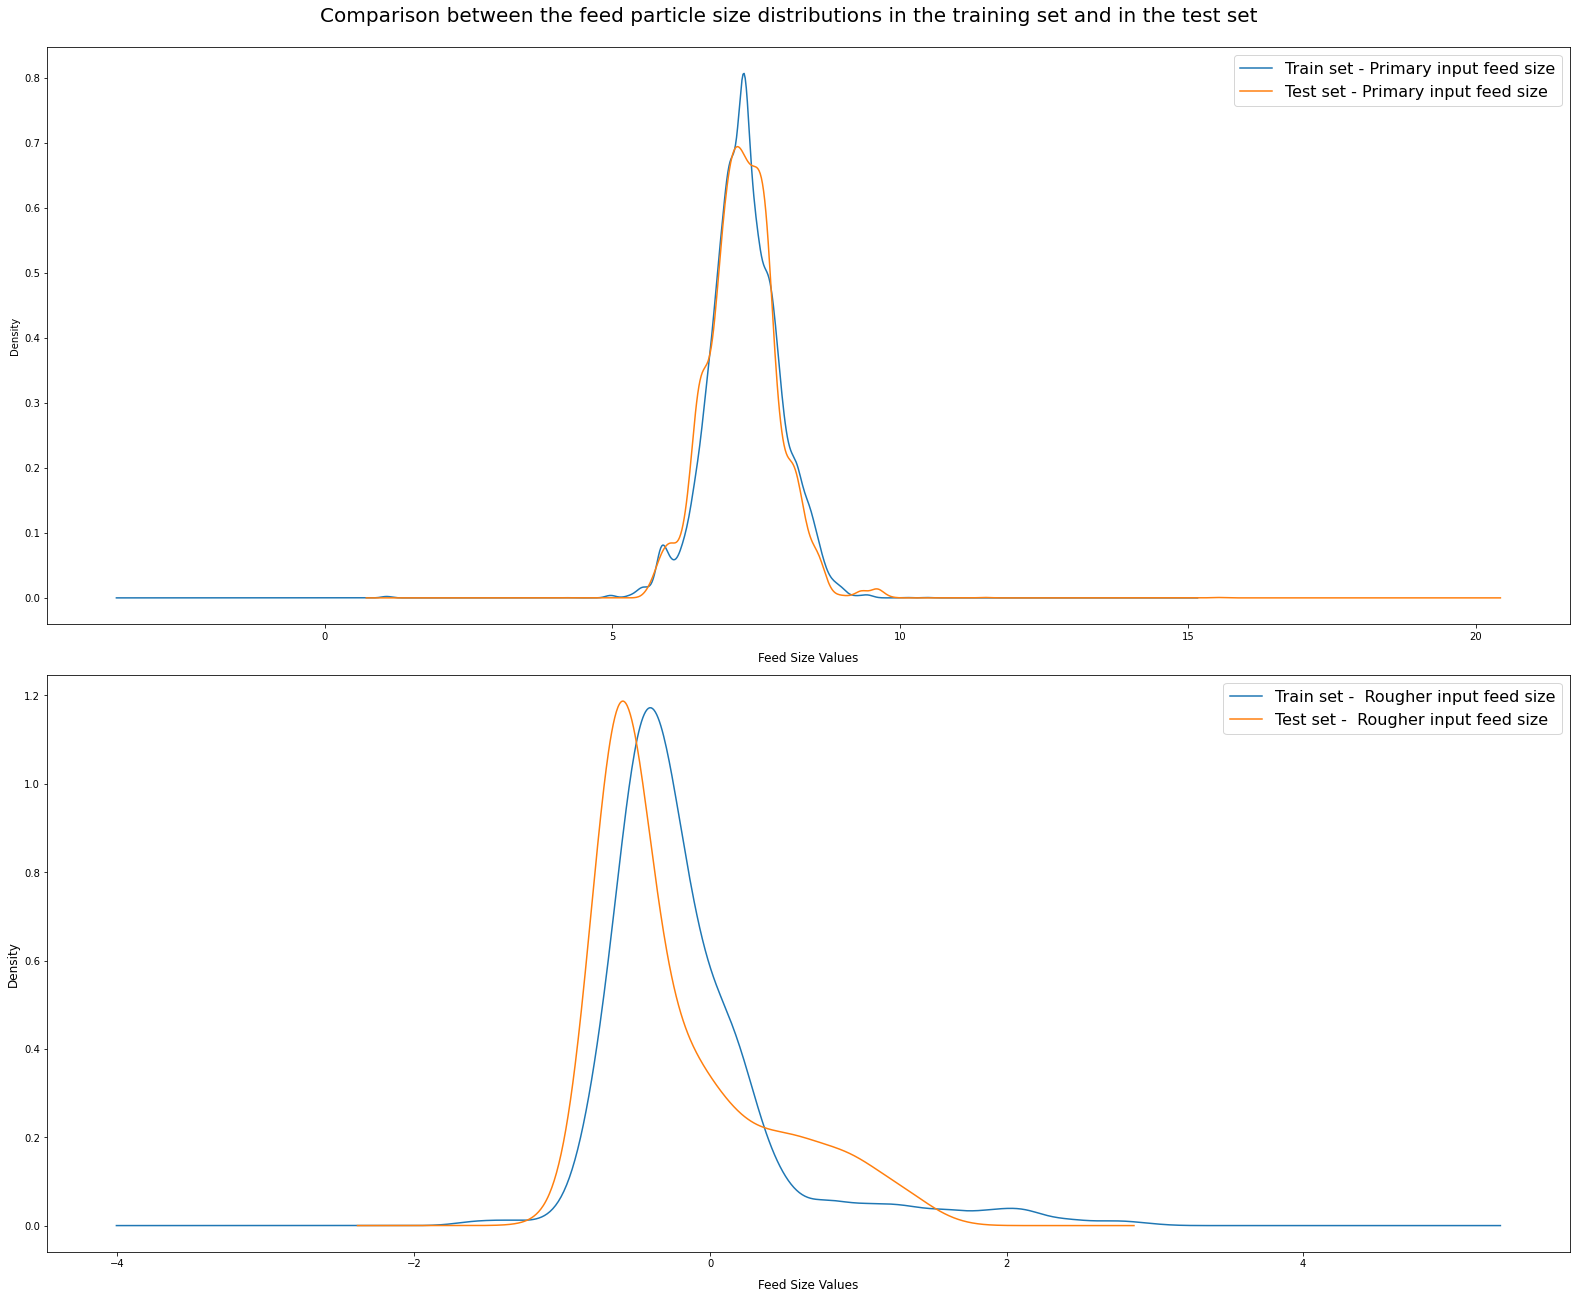

In [48]:
result_columns = ["rougher.input.feed", "rougher.output.concentrate", "primary_cleaner.output.concentrate", "final.output.concentrate"]
metals = ['_au' ,'_ag','_pb']
titles=['Gold' ,'Silver', 'Lead']
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(22, 18), sharey=False)
fig.suptitle('Comparison between the feed particle size distributions in the training set and in the test set', fontsize=20, y=1)

gold_recovery_train['primary_cleaner.input.feed_size'].\
        plot.kde(ax=ax[0],label='Train set - Primary input feed size')
gold_recovery_test['primary_cleaner.input.feed_size'].\
    plot.kde(ax=ax[0],label='Test set - Primary input feed size')
#gold_recovery_test_clean['primary_cleaner.input.feed_size'].\
#    plot.kde(ax=ax[0],label='Clean Test set - Primary input feed size')
gold_recovery_train_clean['rougher.input.feed_size'].\
    plot.kde(ax=ax[1],label='Train set -  Rougher input feed size')
#gold_recovery_test['rougher.input.feed_size'].\
#    plot.kde(ax=ax[1],label='Test set -  Rougher input feed size')
gold_recovery_test_clean['rougher.input.feed_size'].\
    plot.kde(ax=ax[1],label='Test set -  Rougher input feed size')
ax[0].legend(fontsize=16)
ax[1].legend(fontsize=16)
ax[0].set_xlabel('Feed Size Values', fontsize=12, labelpad = 10)
ax[1].set_xlabel('Feed Size Values', fontsize=12, labelpad = 10)
plt.ylabel('Density', fontsize=12)
fig.tight_layout()

#### Conclusion
We see that test set and train set have very similar distributions.

### Total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate.

In [49]:
def total_concentrations(df):
    result_columns = ["rougher.input.feed", "rougher.output.concentrate", "primary_cleaner.output.concentrate", "final.output.concentrate"]
    metals = ['_au' ,'_ag','_pb']
    titles=['Gold' ,'Silver', 'Lead']
    total_concentrations=pd.DataFrame(columns=result_columns)

    for i in range(len(result_columns)):
        total_concentrations[result_columns[i]]=df[result_columns[i]+metals[0]]+\
                                                df[result_columns[i]+metals[1]]+\
                                                df[result_columns[i]+metals[2]]
    return total_concentrations


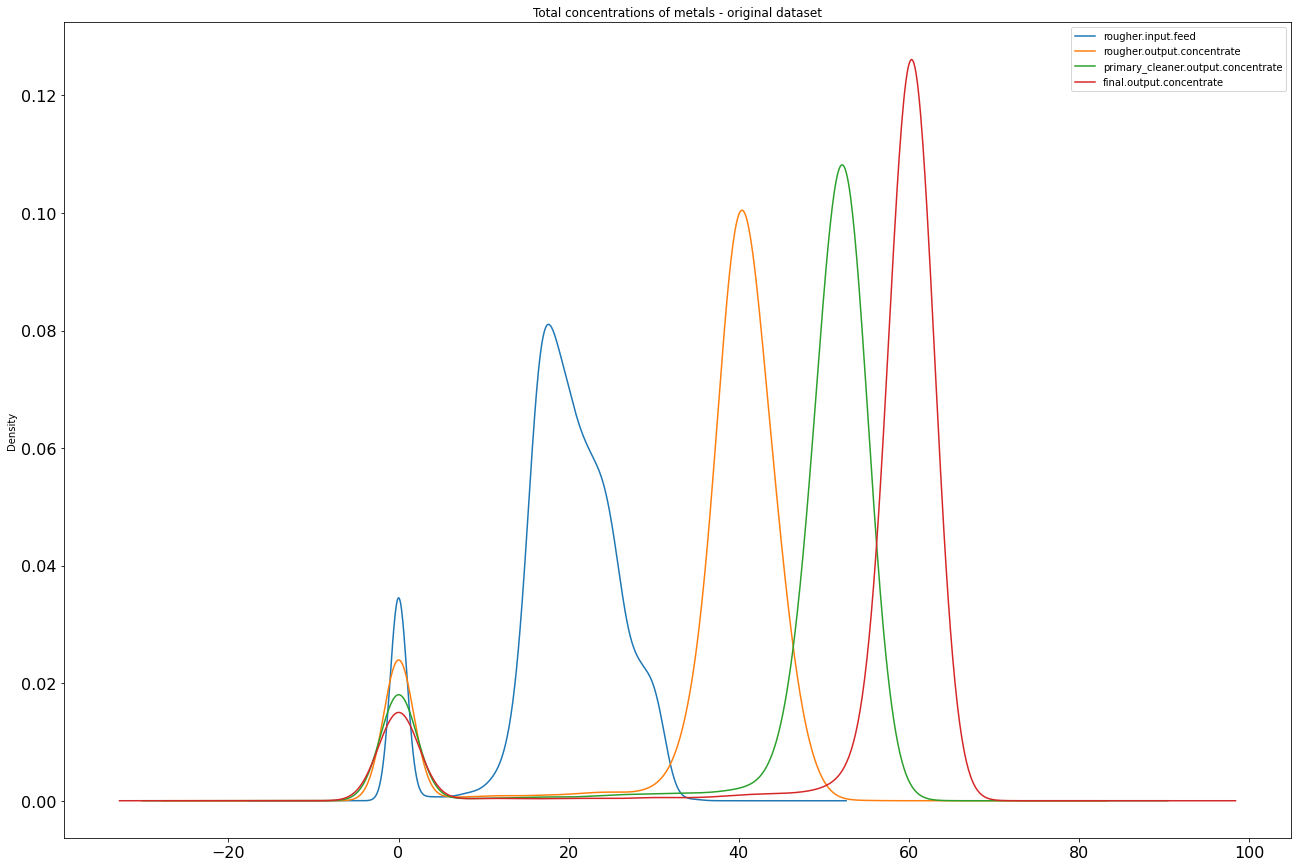

In [50]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(22, 18), sharey=False)

total_concentrations(gold_recovery_full).plot.kde(ax=ax,title='Total concentrations of metals - original dataset',
                                   figsize=(22, 15),
                                   fontsize=16,
                              );
#total_concentrations(gold_recovery_full_unscaled).plot.kde(ax=ax[1],title='Total concentrations of metals - cleaned dataset',
#                                                           figsize=(22, 15),
#                                                           fontsize=16,
#                                                           );
#ax[0].title.set_size(18)
#ax[1].title.set_size(18)


We clearly the increase in concetration of metals in each stage of the purification process. We also see the differences between the origianl dataset and the cleaned data set, which eliminated the outliers and anomalous results and now the concentration is twice as good.

## 3. Build the model

### 3.1. Write a function to calculate the final sMAPE value.

<img src="https://pictures.s3.yandex.net/resources/smape_1576239058_1589899769.jpg">

In [51]:
def smape(actual_values, predicted_values):
    smape = np.mean(abs(predicted_values - actual_values) / ((abs(actual_values) + abs(predicted_values)) / 2)) * 100
    return smape

<img src="https://pictures.s3.yandex.net/resources/_smape_1_1589900649.jpg">


In [52]:
def final_smape(actual_values, predicted_values):
    predicted_rough, predicted_final = predicted_values[:, 0], predicted_values[:, 1]
    true_rough, true_final = actual_values[:, 0], actual_values[:, 1]
    ft_smape = (.25 * (smape(true_rough, predicted_rough))) + (.75 * (smape(true_final, predicted_final)))
    return (-1)*ft_smape        #We return the negative of the score so GridSearchCV will give us the smallest error

### Training models.
We separate the data in features and targets for the train and test sets respectively.

In [53]:
targets_columns = ['rougher.output.recovery', 'final.output.recovery']

features_columns = gold_recovery_test_clean.columns.tolist()  #we only need the features common with the test set
features_columns.remove('date')
features_columns.remove('rougher.output.recovery')
features_columns.remove('final.output.recovery')

target_train= gold_recovery_train_clean[targets_columns]
target_test= gold_recovery_test_clean[targets_columns]

features_train=gold_recovery_train_clean[features_columns]
features_test=gold_recovery_test_clean[features_columns]

We are going to build a class that will remember and organize all the intermediary models and scores to automatize the comparisons between the various machine learning models

In [54]:
class Models:
    def __init__(self):
        self.data=pd.DataFrame(columns=['model_name','model','smape','final_smape','params'])

    def add(self,model_name,model,y_test,y_pred,params={}):
        new_score={
            'model_name':model_name,
            'model':model,
            'smape':smape(y_test,y_pred),
            'final_smape':final_smape(y_test.values,y_pred),
            'params':params
        }
        self.data=self.data.append(new_score,ignore_index=True)
        print('Model Name :',new_score['model'])
        #print(self.data)

    def print(self):
        print(self.data)

    def print_dataframe(self):
        return self.data

    def best_model(self):
        bm=self.data[self.data.final_smape==self.data.final_smape.max()]
        print('The best model so far is :',
              bm.loc[bm.index[0]])
        return bm.loc[bm.index[0],'model'].best_estimator_

    def print_final_scores(self):
        result= pd.DataFrame(data=self.data['final_smape'].round(2).values, index=self.data['model_name'],columns=['Score'])
        result.index.name='Model Name'
        display(result)
scores=Models()

#### Dedcision Tree Regressor

In [55]:
dtr_model_grid=DecisionTreeRegressor(random_state=12345)
#Parameters to check
param_grid_dtr = {
    'max_depth': range(5, 10, 5),
    'min_impurity_decrease' : np.arange(.01, .20, .02),
    'min_samples_split' : range(2, 10, 2)
}
dtr_model_grid = GridSearchCV(estimator=DecisionTreeRegressor(random_state=12345),
                             param_grid=param_grid_dtr, verbose=0, cv=5, scoring=final_smape, refit=True)
dtr_model_grid.fit(features_train, target_train)
predicted_test=dtr_model_grid.predict(features_test)

In [56]:
scores.add('Decision Tree Regressor',dtr_model_grid,target_test,predicted_test,param_grid_dtr)

Model Name : GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(5, 10, 5),
                         'min_impurity_decrease': array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19]),
                         'min_samples_split': range(2, 10, 2)},
             scoring=<function final_smape at 0x0000027BAF02F1F0>)


#### Linear Regression

In [57]:
#Parameters to check
param_grid_lr = {}
lr_model_grid = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid_lr,
                             verbose=0, cv=5, refit=True, scoring=final_smape)
lr_model_grid.fit(features_train, target_train)
predicted_test=lr_model_grid.predict(features_test)
scores.add('Liniar Regression',lr_model_grid,target_test,predicted_test)

Model Name : GridSearchCV(cv=5, estimator=LinearRegression(), param_grid={},
             scoring=<function final_smape at 0x0000027BAF02F1F0>)


#### Random Forest Regressor

In [58]:
#Parameters to check
param_grid_rfr = {'n_estimators' : range(10, 85, 25),
                  'max_depth' : range(5, 45, 10),
                  'min_impurity_decrease' : np.arange(.05, .25, .1)}

In [59]:
rfr_model_grid = GridSearchCV(estimator=RandomForestRegressor(random_state=12345), param_grid=param_grid_rfr,
                             verbose=0, cv=5, refit=True, scoring=final_smape)

In [60]:
rfr_model_grid.fit(features_train, target_train)
predicted_test=rfr_model_grid.predict(features_test)
scores.add('Random Forest Regression', rfr_model_grid, target_test, predicted_test)

Model Name : GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(5, 45, 10),
                         'min_impurity_decrease': array([0.05, 0.15]),
                         'n_estimators': range(10, 85, 25)},
             scoring=<function final_smape at 0x0000027BAF02F1F0>)


#### Lasso Regression

In [61]:
param_grid_lssr = {'alpha' : np.arange(.01, 1, .05)}
lssr_model_grid = GridSearchCV(estimator=Lasso(random_state=12345), param_grid=param_grid_lssr,
                              verbose=0, cv=5, refit=True, scoring=final_smape)
lssr_model_grid.fit(features_train, target_train)
predicted_test=lssr_model_grid.predict(features_test)
scores.add('Lasso Regression', lssr_model_grid, target_test, predicted_test)

Model Name : GridSearchCV(cv=5, estimator=Lasso(random_state=12345),
             param_grid={'alpha': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96])},
             scoring=<function final_smape at 0x0000027BAF02F1F0>)


#### Ridge Regression

In [62]:
param_grid_rr = {'alpha': np.arange(.01, 1, .05)}
rr_model_grid = GridSearchCV(estimator=Ridge(random_state=12345), param_grid=param_grid_rr,
                               verbose=0, cv=5, refit=True, scoring=final_smape)
rr_model_grid.fit(features_train, target_train)
predicted_test=rr_model_grid.predict(features_test)
scores.add('Ridge Regression', rr_model_grid, target_test, predicted_test)


Model Name : GridSearchCV(cv=5, estimator=Ridge(random_state=12345),
             param_grid={'alpha': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96])},
             scoring=<function final_smape at 0x0000027BAF02F1F0>)


In [63]:
scores.print_final_scores()

,Score
Model Name,
Decision Tree Regressor,-10.12
Liniar Regression,-9.96
Random Forest Regression,-9.27
Lasso Regression,-9.60
Ridge Regression,-9.96


In [64]:
scores.data

,model_name,model,smape,final_smape,params
0,Decision Tree Regressor,"GridSearchCV(cv=5, estimator=DecisionTreeRegre...",rougher.output.recovery 7.448831 final.out...,-10.120755,"{'max_depth': (5), 'min_impurity_decrease': [0..."
1,Liniar Regression,"GridSearchCV(cv=5, estimator=LinearRegression(...",rougher.output.recovery 5.340062 final.out...,-9.962194,{}
2,Random Forest Regression,"GridSearchCV(cv=5, estimator=RandomForestRegre...",rougher.output.recovery 6.156968 final.out...,-9.270579,{}
3,Lasso Regression,"GridSearchCV(cv=5, estimator=Lasso(random_stat...",rougher.output.recovery 5.247923 final.out...,-9.596642,{}
4,Ridge Regression,"GridSearchCV(cv=5, estimator=Ridge(random_stat...",rougher.output.recovery 5.339849 final.out...,-9.961337,{}


## Testing the Best Model on the Data Set

In [65]:
best_model=scores.best_model()

The best model so far is : model_name                              Random Forest Regression
model          GridSearchCV(cv=5, estimator=RandomForestRegre...
smape          rougher.output.recovery     6.156968
final.out...
final_smape                                            -9.270579
params                                                        {}
Name: 2, dtype: object


So we see that the best model is Linear Regression. Let's run it on the data set.

In [66]:
best_model.fit(gold_recovery_train_clean.drop(fixed_columns,axis=1),gold_recovery_train_clean[['rougher.output.recovery', 'final.output.recovery']])

RandomForestRegressor(max_depth=5, min_impurity_decrease=0.05, n_estimators=10,
                      random_state=12345)

In [67]:
best_prediction=best_model.predict(gold_recovery_test_clean.drop(fixed_columns,axis=1))
best_score=final_smape(gold_recovery_test_clean[['rougher.output.recovery', 'final.output.recovery']].values, best_prediction)
print('Our best prediction is {:.4f}'.format(best_score))

Our best prediction is -9.2706


 ## Checking Best Model against Sanity Check Models
 We will use the median value of the training set as a sanity check model and we check it's score against the test set.

In [68]:
sanity_check=final_smape(target_test.values,np.tile(np.median(target_train,axis=0),(len(target_test),1)))
print('Final-SMAPE score for the sanity check model is {:.4f}'.format(sanity_check))

Final-SMAPE score for the sanity check model is -8.9490


 ## Final Conclusion
 We had to prepare a model that would predict the amount of gold recovered from gold ore.
 We analyzed the data, scaled it, eliminated nulls and outliers. The cleaned data was tested with various models with a wide range of parameters.

The best model we found gave a score of -9.27 which is slightly worse than the sanity check model. I think further work is necessary.